In [1]:
import sys
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt

from jax import grad,jit, jacfwd
from matplotlib import pyplot as plt
import jax.numpy as jnp

from functools import partial
%load_ext autoreload
%autoreload 2

In [28]:
def sep_func(ps):
    CoM = jnp.mean(ps,axis=0)
    A = ps-CoM
    return jnp.linalg.det(A.T.dot(A))

def mutual_separation_path_planning(R,ps,n_p,n_steps,max_linear_speed,dt):
    step_size = max_linear_speed*dt
    ps=ps.reshape(-1,2)

    f_dLdp = jit(jacfwd(sep_func))
    p_trajs=[]
    n_timesteps = 20
    reached=False
    for i in range(n_timesteps):
            # Calculate the gradient

            CoM= np.mean(ps,axis = 0)
#             print(CoM,ps)
            grad=f_dLdp(ps)
            grad=grad.reshape(-1,2)
            grad_sizes=np.linalg.norm(grad,axis=1)
            grad_sizes[grad_sizes==0]=1 # Handle the case where the partial derivative is zero.

            update_steps=(grad.T/np.max(grad_sizes) * step_size).T # Calculate the update steps to be applied to ps

            candid_ps=np.array(ps+update_steps) # Calculate the direct update 

            # Prevent the ps from getting too far away by doing projection
            for j in range(len(candid_ps)):
                candid_ps[j,:] = CircleInterior(CoM,R).project_point(candid_ps[j,:])
            
            p_trajs.append(candid_ps)
            
            print(np.max(np.linalg.norm(ps-candid_ps,axis=1)))
            if np.max(np.linalg.norm(ps-candid_ps,axis=1))<0.1 and i == 0:
                reached = True
                break
            ps=candid_ps # Update ps.
            
    p_trajs = np.array(p_trajs)
    return p_trajs,reached

0.2200000060739701
0.22000001
0.22
0.22
0.22000001
0.21999995
0.22000003
0.21999998
0.21999995
0.18968272
0.057313424
0.022355283
0.008865573
0.0035386959
0.0014161891
0.0005675246
0.00022748743
9.1091184e-05
3.6485053e-05
1.4545488e-05


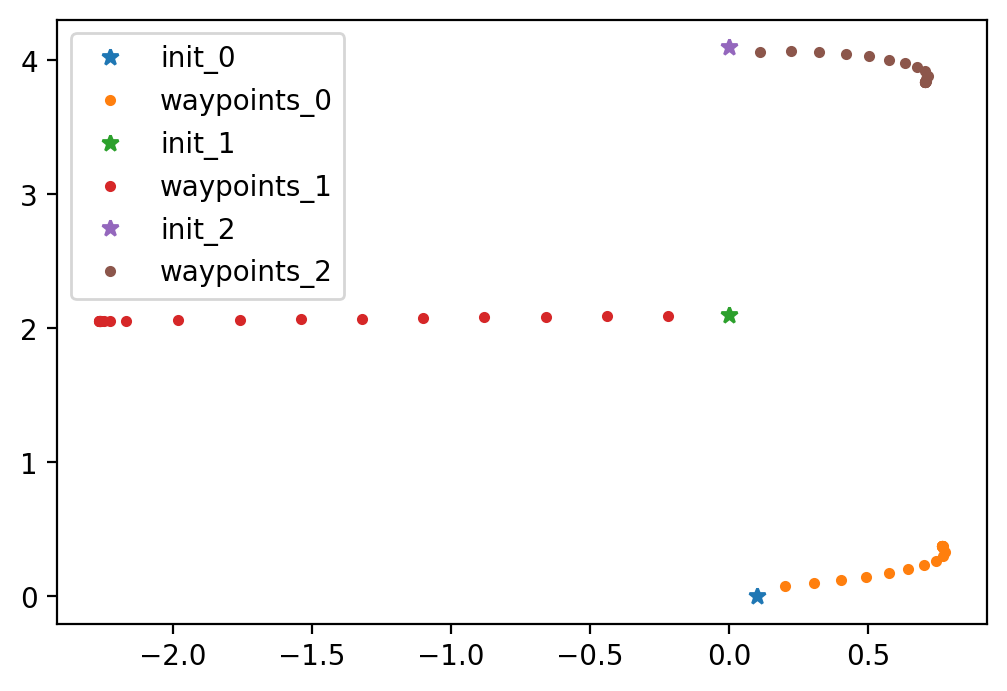

In [32]:
from regions import CircleInterior
R=2
ps=np.array([[0.1,0.],[0.,2.1],[0.,4.1]])
n_p = len(ps)
max_linear_speed=0.22
dt = 1
n_steps = 300
p_trajs=[]

p_trajs,reached = mutual_separation_path_planning(R,ps,n_p,n_steps,max_linear_speed,dt)  
fig = plt.figure(dpi=200)
for i in range(n_p):
    plt.plot(ps[i,0],ps[i,1],'*',label = 'init_{}'.format(i))
    plt.plot(p_trajs[:,i,0],p_trajs[:,i,1],'.',label= 'waypoints_{}'.format(i))
plt.legend()
plt.show()

In [27]:
reached

False